# Conduct SHAP analysis to characterize drift

* Compare drift on External Test versus Traceability sets (mean abs)
* Compare time-evolution of reference set (Training and External Test) and analysis set (Traceability)

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
# SHAP
import shap
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors
# SKLEARN
from sklearn.model_selection import KFold
random_state = 8
PROCESSED = "Prossesed/"

## SHAP Test - Set

#### Normalized Mean Abs Contribution Difference (Original model fitted to both ``EXT`` and ``TRACE``)

In [3]:
# Select and load model to evaluate
arch = "LReg"
with open(f'models/best_model_{arch}', 'rb') as f:
        best_model = pickle.load(f)
print(best_model["model"].steps[-1])

('LReg', LogisticRegression(C=0.0019141649835069155, max_iter=300, penalty=None,
                   random_state=8, solver='newton-cg'))


In [4]:
# Load model and data
with open(f"{PROCESSED}trainCohort", "rb") as fp:
    train = pickle.load(fp)
with open(f"{PROCESSED}externalCohort", "rb") as fp:
    test = pickle.load(fp)
with open(f"{PROCESSED}traceCohort", "rb") as fp:
    trace = pickle.load(fp)

In [5]:
# Load feature subspace
with open("best_features", "rb") as fp:
    best_features = pickle.load(fp)

In [6]:
shap_comp_sets = {
    'train': None,
    'ext': None,
    'trace': None
}

Extract mean SHAP contributions for External Test and Traceability cohorts

In [7]:
SHAP_sets = False
datasets = [train, test, trace]
set_types = ['train', 'ext', 'trace']
if SHAP_sets:
    explainer = shap.Explainer(best_model['model'].predict, train)
    for i in range(1,len(datasets)):
        print(set_types[i])
        # Split set into folds for contribution estimation
        kf = KFold(n_splits=5, random_state=random_state, shuffle=True)
        nFoldSHAP = []
        for fold, _ in kf.split(datasets[i]):
            foldSHAP = explainer(datasets[i].iloc[fold,:]).values
            # Normalize SHAP
            mean_abs = np.mean(np.abs(foldSHAP), axis=0)
            shap_sum = np.sum(mean_abs)
            norm_shap = mean_abs/shap_sum

            nFoldSHAP.append(norm_shap[np.where(norm_shap > 0)])

        shap_comp_sets[set_types[i]] = np.array(nFoldSHAP)
        
    with open(f"SHAP/{arch}_SHAP_sets", "wb") as fp:
        pickle.dump(shap_comp_sets, fp)
else:
    with open(f"SHAP/{arch}_SHAP_sets", "rb") as fp:
        shap_comp_sets = pickle.load(fp)

In [9]:
df_nSHAP_sets = pd.DataFrame(columns=best_features+["source"])
for source in ["ext", "trace"]:

    df_TEMP = pd.DataFrame([list(arr) for arr in shap_comp_sets[source]], columns=best_features)
    df_TEMP["source"] = source

    df_nSHAP_sets = pd.concat([df_nSHAP_sets, df_TEMP], axis=0)

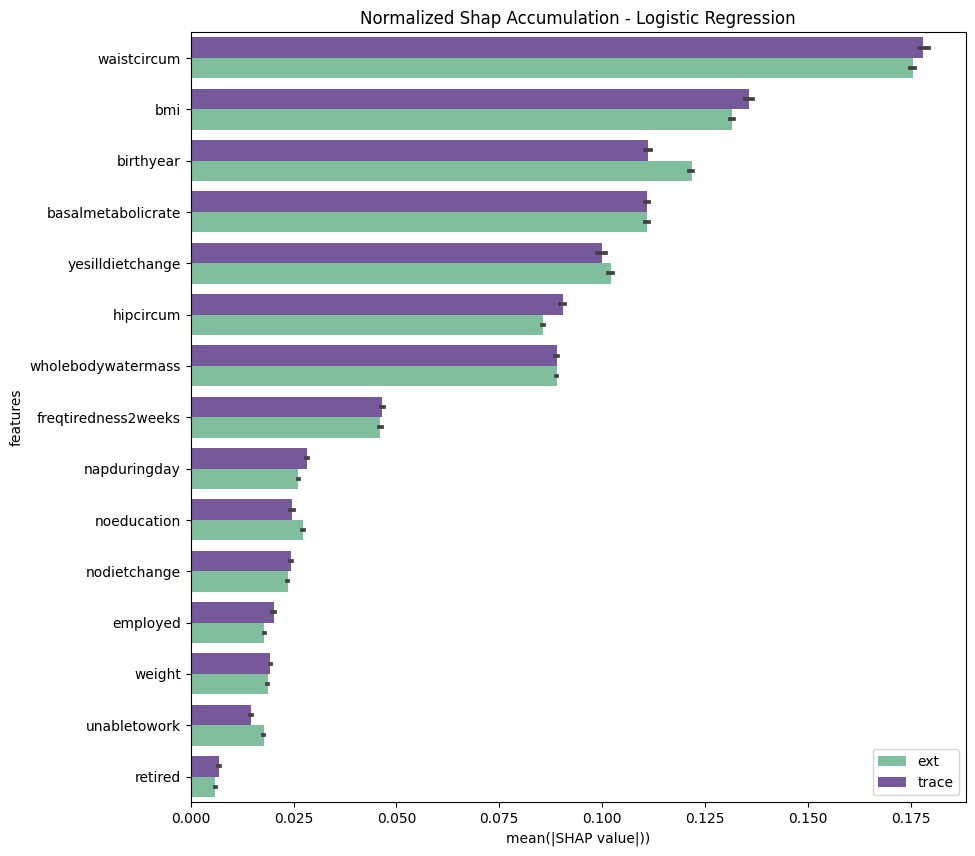

In [10]:
fig, ax = plt.subplots(figsize = (10,10))

#Absolute accumulation
ax = sns.barplot(data=pd.melt(
        df_nSHAP_sets.query("source != 'train'"),
        id_vars=["source"]
    ).reset_index().sort_values("value", ascending=False),
    x="value", y="variable",
    hue='source', palette= [colors.INDIGO_PERSIAN, colors.GREEN_SEA.value], alpha=0.7)

# Force unique legend    
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles, unique_labels)

if arch=="XGB":
    ax.set_title(f"Normalized Shap Accumulation - XGBoost")
else:
    ax.set_title(f"Normalized Shap Accumulation - Logistic Regression")
ax.set_xlabel("mean(|SHAP value|))")
ax.set_ylabel("features")

plt.show()

In [12]:
extTrace_absMeanDiff = np.abs(df_nSHAP_sets.query("source == 'ext'").drop("source", axis=1).mean() - df_nSHAP_sets.query("source == 'trace'").drop("source", axis=1).mean())
extTrace_absMeanDiff.sort_values(ascending=False)

birthyear              0.010724
hipcircum              0.004688
bmi                    0.004199
unabletowork           0.003160
noeducation            0.002695
waistcircum            0.002606
employed               0.002325
yesilldietchange       0.002239
napduringday           0.002087
retired                0.000884
nodietchange           0.000848
weight                 0.000599
freqtiredness2weeks    0.000457
wholebodywatermass     0.000129
basalmetabolicrate     0.000003
dtype: float64

## Summary of SHAP contribution and covariate drifts

Top 5 features in terms of importance shift

In [13]:
nSHAP_top_drift_features = np.array([
    'birthyear',
    'hipcircum',
    'bmi',
    'unabletowork',
    'noeducation'
])

Univariate features with detected covariate drift

In [14]:
data_drift_features = np.array([
    'noeducation',
    'freqtiredness2weeks',
    'bmi',
    'birthyear'
])

## SHAP Test - Time

#### Time Series analysis of SHAP values

In [15]:
train_restricted = train.iloc[:, best_model["features"]]
ext_restricted = test.iloc[:, best_model["features"]]  

trace_restricted = trace.iloc[:, best_model["features"]]

In [16]:
timeline = pd.read_csv("Data/f.53.tab",
            delimiter="\t",
            index_col="f.eid",
            parse_dates=['f.53.0.0', 'f.53.1.0'],
            usecols=['f.eid','f.53.0.0', 'f.53.1.0'])

In [17]:
trainOrdered = train_restricted.merge(
    timeline['f.53.0.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.0.0': 'time'}, axis=1).sort_values('time')

extOrdered = ext_restricted.merge(
    timeline['f.53.0.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.0.0': 'time'}, axis=1).sort_values('time')

traceOrdered = trace_restricted.merge(
    timeline['f.53.1.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.1.0': 'time'}, axis=1).sort_values('time')

In [18]:
trainExtOrdered = pd.concat(
    [trainOrdered, extOrdered],
    axis=0).sort_values("time")

In [19]:
def split_dataframe(df, chunk_size):
    chunks = []
    num_chunks = len(df) // chunk_size
    remainder = len(df) % chunk_size
    
    # Split the DataFrame into chunks of chunk_size
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunks.append(df[start:end])
    
    # Handle the remainder
    if remainder != 0:
        chunks.append(df[-remainder:])
    
    return chunks

chunk_size = 500
evalBatches = []
split_data = split_dataframe(trainExtOrdered, chunk_size)

# Access individual splits
for i, split in enumerate(split_data):
    batchDict = {
        "data": None,
        "startDate": None,
        "endDate": None,
        "Source" : None,
        "nSHAP" : None
    }
    batchDict["data"] = split.drop("time", axis=1)
    batchDict["startDate"] = split.time.min()
    batchDict["endDate"] = split.time.max()
    batchDict["Source"] = "reference"

    evalBatches.append(batchDict)

split_data = split_dataframe(traceOrdered, chunk_size)
for i, split in enumerate(split_data):
    batchDict = {
        "data": None,
        "startDate": None,
        "endDate": None,
        "Source" : None,
        "nSHAP" : None
    }
    batchDict["data"] = split.drop("time", axis=1)
    batchDict["startDate"] = split.time.min()
    batchDict["endDate"] = split.time.max()
    batchDict["Source"] = "analysis"

    evalBatches.append(batchDict)

In [20]:
allData = pd.concat([train, test, trace], axis=0)

In [21]:
SHAP_time = False
if SHAP_time:
    explainer = shap.Explainer(best_model['model'].predict, train)
    for i in range(len(evalBatches)): #Over all eval sets
        if evalBatches[i]["data"].shape[0] >= 30: # Estimate SHAP values for month
            kf = KFold(n_splits=5, random_state=random_state, shuffle=True)
            subBatchNormShap = []
            eids = evalBatches[i]["data"].index
            data = allData.loc[allData.index.isin(eids)]
            for subBatch, _ in kf.split(evalBatches[i]["data"]):
                subBatchSHAP = explainer(data.iloc[subBatch,:]).values
                # Normalize SHAP
                mean_abs = np.mean(np.abs(subBatchSHAP), axis=0)
                shap_sum = np.sum(mean_abs)
                norm_shap = mean_abs/shap_sum

                subBatchNormShap.append(norm_shap[np.where(norm_shap > 0)])

            evalBatches[i]["nSHAP"] = subBatchNormShap
        else:
            continue
    
    with open(f"SHAP/{arch}_SHAP_time", "wb") as fp:
        pickle.dump(evalBatches, fp)
    shap_comp_time = evalBatches
else:
    with open(f"SHAP/{arch}_SHAP_time", "rb") as fp:
        shap_comp_time = pickle.load(fp)

In [22]:
df_nSHAP_time = pd.DataFrame(columns=best_features+["date_end", "date", "source"])

for nSHAPDict in shap_comp_time:
    if nSHAPDict["nSHAP"] is not None:
    
        TEMP = []
        date = nSHAPDict["startDate"]
        source = nSHAPDict["Source"]
        
        for arr in nSHAPDict["nSHAP"]:
            TEMP.append(arr)

        df_TEMP = pd.DataFrame(TEMP, columns=best_features)
        df_TEMP["date_end"] = nSHAPDict["endDate"]
        df_TEMP["date"] = date
        df_TEMP["source"] = source

        df_nSHAP_time = pd.concat([df_nSHAP_time, df_TEMP], axis=0)
    else:
        continue


In [23]:
type_dict = {col:"float" for col in best_features }
type_dict["date"] = "datetime64[ns]"
type_dict["source"] = "str"
df_nSHAP_time = df_nSHAP_time.astype(type_dict)

In [24]:
df_nSHAP_time = df_nSHAP_time.sort_values("date").reset_index(drop=True)
reference_end = df_nSHAP_time.query("source == 'reference'").date.max()
analysis_start = df_nSHAP_time.query("source == 'analysis'").date.min()

In [25]:
GROUPED_std = df_nSHAP_time.groupby(["date", "date_end", "source"]).std()
GROUPED_mean = df_nSHAP_time.groupby(["date", "date_end", "source"]).mean()

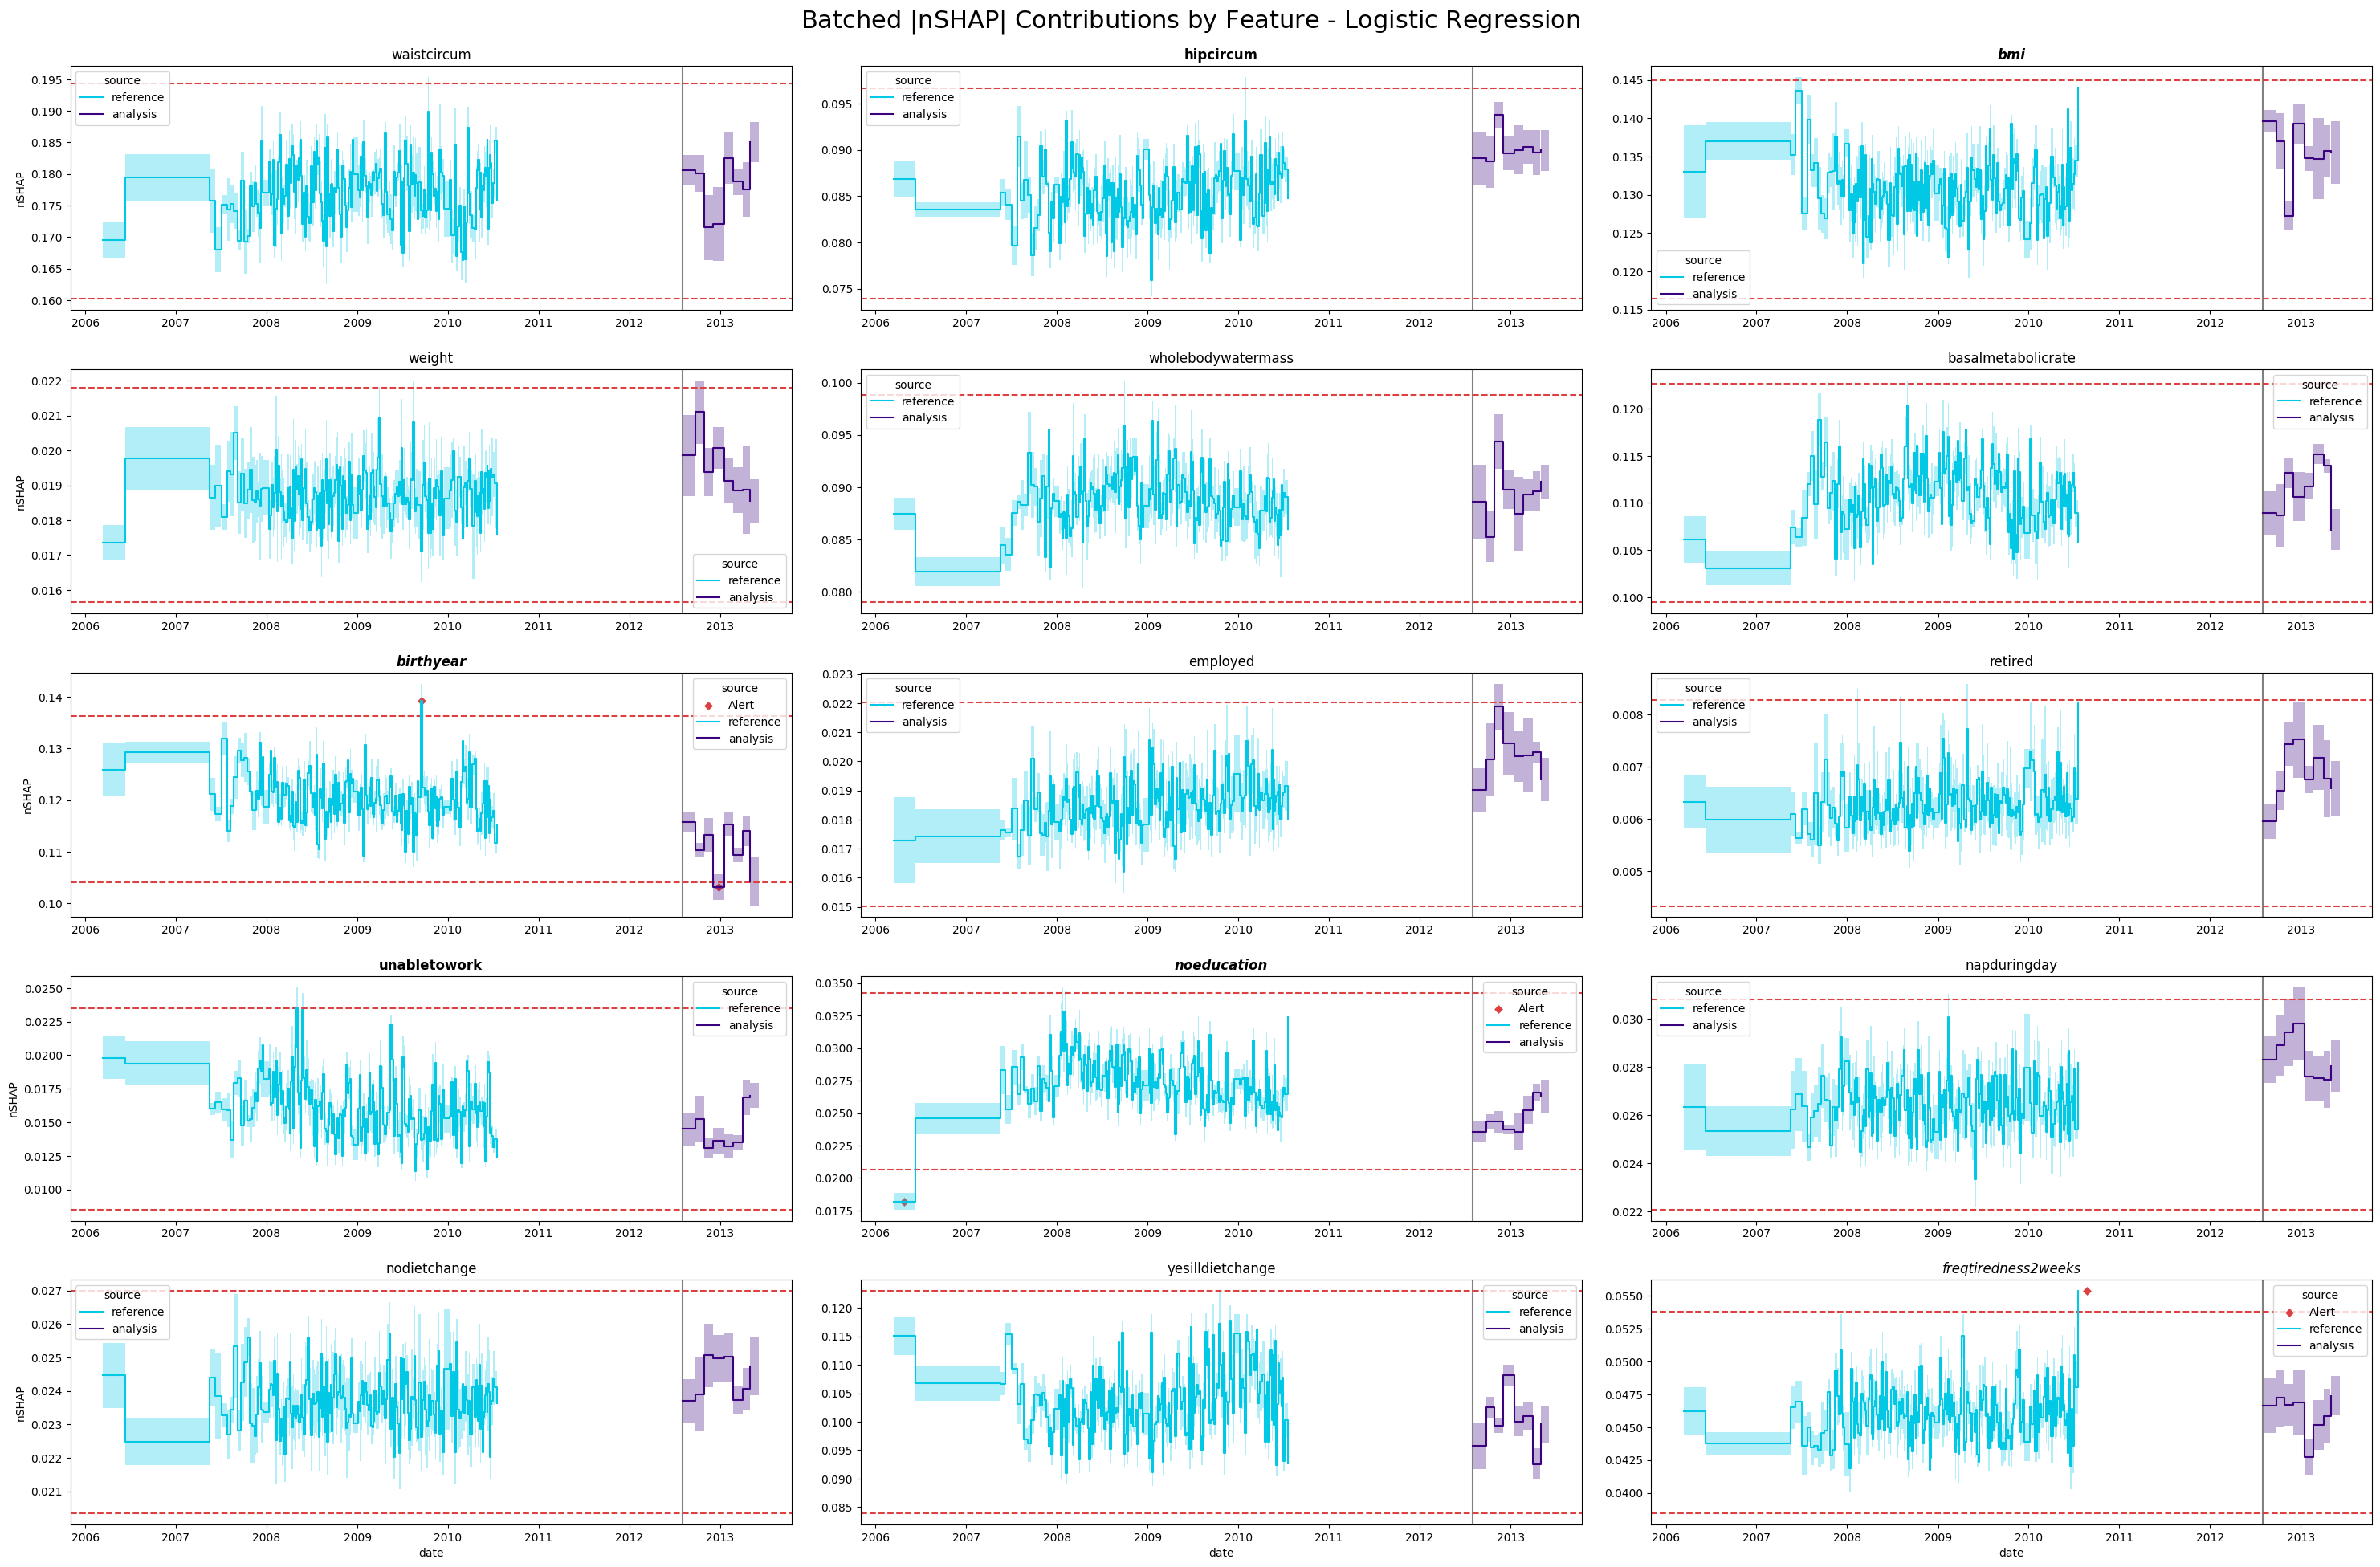

In [26]:
fig, ax = plt.subplots(5, 3, figsize=(30,20))
for i,row in enumerate([
        [0,1,2],
        [3,4,5],
        [6,7,8],
        [9,10,11],
        [12,13,14]]):
    for j,col in enumerate(row):
        
        df = pd.DataFrame(df_nSHAP_time.iloc[:,[col,-2,-1]])
        df['error'] = df_nSHAP_time.iloc[:,col]
        ax[i,j].axvline(x=analysis_start, linestyle="-", color='grey')

        reference_mean = df_nSHAP_time.query("source == 'reference'").drop(['date_end', 'date', 'source'], axis=1).mean()[col]
        reference_std = df_nSHAP_time.query("source == 'reference'").drop(['date_end', 'date', 'source'], axis=1).std()[col]

        ax[i,j].axhline(y= reference_mean + 3*reference_std, linestyle="--", color=colors.RED_IMPERIAL)
        ax[i,j].axhline(y= reference_mean - 3*reference_std, linestyle="--", color=colors.RED_IMPERIAL)

        ALERT_date = []
        ALERT_value = []
        for k, indx in enumerate(GROUPED_mean.index):
            mean = GROUPED_mean.iloc[k,col]
            if (mean > reference_mean + 3*reference_std) or (mean < reference_mean - 3*reference_std):
                midDate = indx[1] - indx[0]
                ALERT_date.append(indx[0]+timedelta(days=midDate.days/2))
                ALERT_value.append(mean)
        
        ax[i,j] = sns.scatterplot(x=ALERT_date, y=ALERT_value, marker="D", color=colors.RED_IMPERIAL, label="Alert", ax=ax[i,j])
        ax[i,j] = sns.lineplot(
            x=df.date, y=df.columns[0],
            data=df, ax=ax[i,j], drawstyle='steps-post',
            hue="source", palette = [colors.BLUE_SKY_CRAYOLA, colors.INDIGO_PERSIAN],
            ci=None
            )
        for k, indx in enumerate(GROUPED_mean.index):
            std = GROUPED_std.iloc[k,col]
            mean = GROUPED_mean.iloc[k,col]
            upper = mean + std
            lower = mean - std
            start = indx[0]
            end = indx[1]
            source = indx[2]

            if source == "reference":
                if GROUPED_mean.index[k+1][2] == "analysis":
                    continue
                ax[i,j].fill("j", "k", colors.BLUE_SKY_CRAYOLA, alpha=0.3,
                    data={"j": [start, end, end, start],
                    "k": [lower, lower, upper, upper]})
            else:
                ax[i,j].fill("j", "k", colors.INDIGO_PERSIAN, alpha=0.3,
                    data={"j": [start, end, end, start],
                    "k": [lower, lower, upper, upper]})

        if df.columns[0] in data_drift_features:
            if df.columns[0] in nSHAP_top_drift_features:
                ax[i,j].set_title(df.columns[0], style='italic', fontweight="bold")
            else:
                ax[i,j].set_title(df.columns[0], style='italic')
        else:
            if df.columns[0] in nSHAP_top_drift_features:
                ax[i,j].set_title(df.columns[0], fontweight="bold")
            else:
                ax[i,j].set_title(df.columns[0])

        ax[i,j].set_ylabel("nSHAP")
        
        if j>0:
            ax[i,j].set(ylabel=None)

        if col<12:
            ax[i,j].set(xlabel=None)
if arch=="XGB":
    plt.suptitle("Batched $|\operatorname{nSHAP}|$ Contributions by Feature - XGBoost", fontsize = 22)
else:
    plt.suptitle("Batched $|\operatorname{nSHAP}|$ Contributions by Feature - Logistic Regression", fontsize = 22)
plt.tight_layout(pad=2)
plt.show()

**Bold** = SHAP Drift

*Itallic* = Data Drift

***Bold & Itallic*** = Both Data and SHAP Drift